<a 
href="https://colab.research.google.com/github/wingated/cs474_labs_f2019/blob/master/DL_Lab9.ipynb"
  target="_parent">
  <img
    src="https://colab.research.google.com/assets/colab-badge.svg"
    alt="Open In Colab"/>
</a>

# Lab 9: Deep Reinforcement Learning

## Objective

- Build DQN and PPO Deep RL algorithms
- Learn the difference between Q Learning and Policy Gradient techniques

## Deliverable

For this lab you will submit an IPython notebook via Learning Suite. This lab gives you a lot of code, and you should only need to modify two of the cells of this notebook, but you can modify any of the given code if you wish.

## Tips

Deep reinforcement learning is difficult. We provide hyperparameters, visualizations, and code for gathering experience, but require you to code up algorithms for training your networks. 

- Your networks should be able to demonstrate learning on cartpole within a minute of wall time.

- Understand what your the starter code is doing. This will help you with the *TODO* sections. The main code block is similar for the two algorithms with some small yet important differences.

- We provide hyperparameters for you to start with. Feel free to experiment with different values, but these worked for us.

- **Print dtypes and shapes** throughout your code to make sure your tensors look the way you expect.

- The DQN algorithm is significantly more unstable than PPO. Even with a correct implementation it may fail to learn every 1/10 times.

- Unfortunately visualizing your agent acting in the environment is non-trivial in Colab. You can visualize your agent by running this code locally and uncommenting the `env.render()` line.

## Grading

- 35% Part 1: DQN *TODO* methods
- 35% Part 2: PPO *TODO* methods
- 20% Cartpole learning curves for DQN and PPO
- 10% Tidy legible code

___

## Cartpole

Cartpole is a simple environment to get your agent up and running. It has a continuous state space of 4 dimensions and a discrete action space of 2. The agent is given a reward of 1 for each timestep it remains standing. Your agent should be able to reach close to 200 cumulative reward for an episode after a minute or two of training. The below graphs show example results for dqn (left) and ppo (right).

![alt text](https://drive.google.com/uc?export=view&id=1Bpz1jOPMF1zJMW6XBJJ44sJ-RmO_q6_U)
![alt text](https://drive.google.com/uc?export=view&id=1M1yygXhLKDL8qfRXn7fh_K-zq7-pQRhY)

___

# Starter Code

## Init

In [ ]:
! pip3 install gym
! pip3 install torch

In [ ]:
import gym
import torch
import torch.nn as nn
from itertools import chain
import matplotlib.pyplot as plt
from tqdm import tqdm
import random
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pdb

## Part 1: DQN

Deep Q-Network (https://www.cs.toronto.edu/~vmnih/docs/dqn.pdf) is a Q-learning algorithm that learns values for state-action pairs.

Actions are sampled according to an $\epsilon-greedy$ policy to help with exploration of the state space. Every time an action is sampled, the agent chooses a random action with $\epsilon$ probability. Otherwise, the agent selects the action with the highest Q-value for a state. $\epsilon$ decays over time according to $\epsilon \gets \epsilon * epsilon\_decay$.

Tuples of state, action, reward, next_state, and terminal $(s,a,r,s',d)$ are collected during training. Every $learn\_frequency$ steps $sample\_size$ tuples are sampled and made into 5 tensors tensors of states, actions, rewarads, next_states, and terminals.

The loss for a batch of size N is given below.

$Loss=\frac{1}{N}\sum \bigg(Q(s,a) - (r + \gamma \underset{a'\sim A}{max} \hat{Q}(s',a')(1-d))\bigg)^2 $

Loss is calculated and used to update the Q-Network. The target network $\hat{Q}$ begins as a copy of the Q network but is not updated by the optimizer. Every $target\_update$ steps, the target network is updated with the parameters of the Q-Network. This processes is a type of bootstrapping.

### TODO

- Implement get action method with e-greedy policy
- Implement sample batch method
- Implement DQN learning algorithm
- Train DQN on cartpole
- Display learning curves with average episodic reward per epoch

In [ ]:
def get_action_dqn(network, state, epsilon, epsilon_decay):
  """Select action according to e-greedy policy and decay epsilon

    Args:
        network (QNetwork): Q-Network
        state (np-array): current state, size (state_size)
        epsilon (float): probability of choosing a random action
        epsilon_decay (float): amount by which to decay epsilon

    Returns:
        action (int): chosen action [0, action_size)
        epsilon (float): decayed epsilon
  """
  actions = [0, 1, 2]
  weights = np.array([epsilon/2, epsilon/2, 1-epsilon])
  action = np.random.choice(actions, p=weights, size=1)[0]
  if action == 2:
    state = torch.tensor(state).float().cuda()
    results = network(state)
    action = int(torch.argmax(results).item())
  return action, epsilon*epsilon_decay


def prepare_batch(memory, batch_size):
  """Randomly sample batch from memory
     Prepare cuda tensors

    Args:
        memory (list): state, action, next_state, reward, done tuples
        batch_size (int): amount of memory to sample into a batch

    Returns:
        state (tensor): float cuda tensor of size (batch_size x state_size()
        action (tensor): long tensor of size (batch_size)
        next_state (tensor): float cuda tensor of size (batch_size x state_size)
        reward (tensor): float cuda tensor of size (batch_size)
        done (tensor): float cuda tensor of size (batch_size)
  """
  sample = random.sample(memory, batch_size)
  states = []
  actions = []
  nexts = []
  rewards = []
  dones = []
  for entry in sample:
      states.append(np.array(entry[0]).astype(np.float))
      actions.append(entry[1])
      nexts.append(np.array(entry[2]).astype(np.float))
      rewards.append(entry[3])
      dones.append(entry[4])

  states = torch.tensor(states).float().cuda()
  actions = torch.tensor(np.array(actions, dtype=int)).cuda()
  nexts = torch.tensor(nexts).float().cuda()
  rewards = torch.tensor(np.array(rewards)).float().cuda()
  dones = torch.tensor(np.array(dones)).float().cuda()

  return (states, actions, nexts, rewards, dones)  
  
  
def learn_dqn(batch, optim, q_network, target_network, gamma, global_step, target_update):
  """Update Q-Network according to DQN Loss function
     Update Target Network every target_update global steps
 
    Args:
        batch (tuple): tuple of state, action, next_state, reward, and done tensors
        optim (Adam): Q-Network optimizer
        q_network (QNetwork): Q-Network
        target_network (QNetwork): Target Q-Network
        gamma (float): discount factor
        global_step (int): total steps taken in environment
        target_update (int): frequency of target network update
  

  oneHotAct = []
  for act in batch[1]:
      acc = [0, 0]
      acc[act.item()] = 1
      oneHotAct.append(acc)

  optim.zero_grad()  
  q_values = q_network(batch[0]) * torch.tensor(oneHotAct).cuda()
  q_values = torch.max(q_values, 1).values
  max_q_prime = torch.max(target_network(batch[2]), 1).values
  target_q = batch[3] + (max_q_prime * (1-batch[4]) * gamma)
  loss = nn.MSELoss()
  output = loss(q_values, target_q)
  output.backward()
  optim.step()
"""
  
  optim.zero_grad()
  loss = 0
  for state, action, next_state, reward, done in zip(*batch):
      item_loss = q_network(state)[action] - (reward + ((1-done)*gamma*torch.max(target_network(next_state))))
      loss += item_loss**2
  loss = loss / len(batch[0])
  loss.backward()
  optim.step()

  if global_step % target_update == 0:
    target_network.load_state_dict(q_network.state_dict()) 
  
  return loss.item()

### Modules

In [ ]:
# Q-Value Network
class QNetwork(nn.Module):
  def __init__(self, state_size, action_size):
    super().__init__()
    hidden_size = 8
    
    self.net = nn.Sequential(nn.Linear(state_size, hidden_size),
                             nn.ReLU(),
                             nn.Linear(hidden_size, hidden_size),
                             nn.ReLU(),
                             nn.Linear(hidden_size, hidden_size),
                             nn.ReLU(),
                             nn.Linear(hidden_size, action_size))  
    
  def forward(self, x):
    return self.net(x)

### Main

In [ ]:
def dqn_main():
  # Hyper parameters
  lr = 1e-3
  epochs = 250
  start_training = 100
  gamma = 0.99
  batch_size = 32
  epsilon = 1
  epsilon_decay = .9999
  target_update = 1000
  learn_frequency = 2

  # Init environment
  state_size = 4
  action_size = 2
  env = gym.make('CartPole-v1', )

  # Init networks
  q_network = QNetwork(state_size, action_size).cuda()
  target_network = QNetwork(state_size, action_size).cuda()
  target_network.load_state_dict(q_network.state_dict())

  # Init optimizer
  optim = torch.optim.Adam(q_network.parameters(), lr=lr)

  # Init replay buffer
  memory = []

  # Begin main loop
  results_dqn = []
  loss_dqn = []
  global_step = 0
  loop = tqdm(total=epochs, position=0, leave=False)
  for epoch in range(epochs):

    # Reset environment
    state = env.reset()
    done = False
    cum_reward = 0  # Track cumulative reward per episode

    # Begin episode
    while not done and cum_reward < 200:  # End after 200 steps 
      # Select e-greedy action
      action, epsilon = get_action_dqn(q_network, state, epsilon, epsilon_decay)

      # Take step
      next_state, reward, done, _ = env.step(action)
      # env.render()

      # Store step in replay buffer
      memory.append((state, action, next_state, reward, done))

      cum_reward += reward
      global_step += 1  # Increment total steps
      state = next_state  # Set current state

      # If time to train
      if global_step > start_training and global_step % learn_frequency == 0:

        # Sample batch
        batch = prepare_batch(memory, batch_size)
        
        # Train
        loss = learn_dqn(batch, optim, q_network, target_network, gamma, global_step, target_update)
        loss_dqn.append(loss)

    # Print results at end of episode
    results_dqn.append(cum_reward)
    loop.update(1)
    loop.set_description('Episodes: {} Reward: {}'.format(epoch, cum_reward))
  
  return results_dqn, loss_dqn

results_dqn, loss_dqn = dqn_main()

/usr/local/lib/python3.7/dist-packages/gym/core.py:318: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  "Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future."
/usr/local/lib/python3.7/dist-packages/gym/wrappers/step_api_compatibility.py:40: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  "Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future."
Episodes: 3 Reward: 22.0:   2%|▏         |

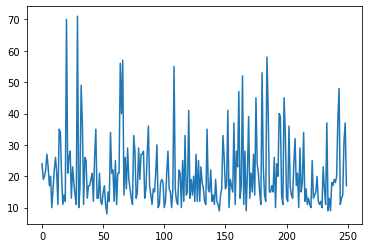

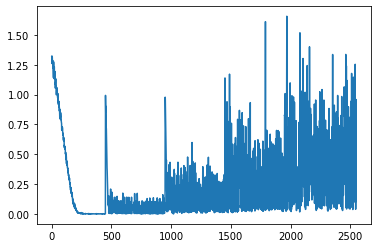

In [ ]:
plt.plot(results_dqn)
plt.show()
plt.plot(loss_dqn)
plt.show()

## Part 2: PPO

Proximal Policy Optimization (https://arxiv.org/pdf/1707.06347.pdf) is a type of policy gradient method. Instead of calculating Q-values, we train a network $\pi$ to optimize the probability of taking good actions directly, using states as inputs and actions as outputs. PPO also uses a value network $V$ that estimates state values in order to estimate the advantage $\hat{A}$. 

Tuples of state, action distribution, action taken, and return $(s,\pi(s), a,\hat{R})$ are gathered for several rollouts. After training on this experience, these tuples are discarded and new experience is gathered.

Loss for the value network and the policy network are calculated according to the following formula:

$Loss=ValueLoss+PolicyLoss$

$ValueLoss=\frac{1}{N}\sum \bigg(\hat{R} - V(s) \bigg)^2 $

$PolicyLoss=-\frac{1}{N}\sum \min\bigg( \frac{\pi'(a|s)}{\pi(a|s)} \hat{A}, clip(\frac{\pi'(a|s)}{\pi(a|s)},1-\epsilon,1+\epsilon) \hat{A} \bigg) $

$\hat{R}_t = \sum_{i=t}^H \gamma^{i-1}r_i$

$\hat{A}_t=\hat{R}_t-V(s_t)$

Here, $\pi'(a|s)$ is the probability of taking an action given a state under the current policy and $\pi(a|s)$ is the probability of taking an action given a state under the policy used to gather data. In the loss function, $a$ is the action your agent actually took and is sampled from memory. 

Additionally, the $clip$ function clips the value of the first argument according to the lower and upper bounds in the second and third arguments resectively.

Another important note: Your the calculation of your advantage $\hat{A}$ should not permit gradient flow from your policy loss calculation. In other words, make sure to call `.detach()` on your advantage.

### TODO

- Implement calculate return method
- Implement get action method
- Implement PPO learning algorithm
- Train PPO on cartpole
- Display learning curves with average episodic reward per epoch

In [ ]:
def calculate_return(memory, rollout, gamma):
  """Return memory with calculated return in experience tuple

    Args:
        memory (list): (state, action, action_dist, return) tuples
        rollout (list): (state, action, action_dist, reward) tuples from last rollout
        gamma (float): discount factor

    Returns:
        list: memory updated with (state, action, action_dist, return) tuples from rollout
  """
  pass


def get_action_ppo(network, state):
  """Sample action from the distribution obtained from the policy network

    Args:
        network (PolicyNetwork): Policy Network
        state (np-array): current state, size (state_size)

    Returns:
        int: action sampled from output distribution of policy network
        array: output distribution of policy network
  """
  state = torch.tensor(state).float().cuda()
  print(state.shape, state.dtype)
  result = np.array(network(state))
  print(result)
  action = np.random.choice([0, 1], p=result, size=1)[0]
  return action, result
  

def learn_ppo(optim, policy, value, memory_dataloader, epsilon, policy_epochs):
  """Implement PPO policy and value network updates. Iterate over your entire 
     memory the number of times indicated by policy_epochs.    

    Args:
        optim (Adam): value and policy optimizer
        policy (PolicyNetwork): Policy Network
        value (ValueNetwork): Value Network
        memory_dataloader (DataLoader): dataloader with (state, action, action_dist, return, discounted_sum_rew) tensors
        epsilon (float): trust region
        policy_epochs (int): number of times to iterate over all memory
  """
  pass 

### Modules

In [ ]:
# Dataset that wraps memory for a dataloader
class RLDataset(Dataset):
  def __init__(self, data):
    super().__init__()
    self.data = []
    for d in data:
      self.data.append(d)
  
  def __getitem__(self, index):
    return self.data[index]
 
  def __len__(self):
    return len(self.data)


# Policy Network
class PolicyNetwork(nn.Module):
  def __init__(self, state_size, action_size):
    super().__init__()
    hidden_size = 8
    
    self.net = nn.Sequential(nn.Linear(state_size, hidden_size),
                             nn.ReLU(),
                             nn.Linear(hidden_size, hidden_size),
                             nn.ReLU(),
                             nn.Linear(hidden_size, hidden_size),
                             nn.ReLU(),
                             nn.Linear(hidden_size, action_size))
  
  def forward(self, x):
    """Get policy from state

      Args:
          state (tensor): current state, size (batch x state_size)

      Returns:
          action_dist (tensor): probability distribution over actions (batch x action_size)
    """
    partial = self.net(x)
    print(partial)
    return partial
  

# Value Network
class ValueNetwork(nn.Module):
  def __init__(self, state_size):
    super().__init__()
    hidden_size = 8
  
    self.net = nn.Sequential(nn.Linear(state_size, hidden_size),
                             nn.ReLU(),
                             nn.Linear(hidden_size, hidden_size),
                             nn.ReLU(),
                             nn.Linear(hidden_size, hidden_size),
                             nn.ReLU(),
                             nn.Linear(hidden_size, 1))
    
  def forward(self, x):
    """Estimate value given state

      Args:
          state (tensor): current state, size (batch x state_size)

      Returns:
          value (tensor): estimated value, size (batch)
    """
    return self.net(x)

### Main

In [ ]:
def ppo_main():
  # Hyper parameters
  lr = 1e-3
  epochs = 20
  env_samples = 100
  gamma = 0.9
  batch_size = 256
  epsilon = 0.2
  policy_epochs = 5

  # Init environment 
  state_size = 4
  action_size = 2
  env = gym.make('CartPole-v1')

  # Init networks
  policy_network = PolicyNetwork(state_size, action_size).cuda()
  value_network = ValueNetwork(state_size).cuda()

  # Init optimizer
  optim = torch.optim.Adam(chain(policy_network.parameters(), value_network.parameters()), lr=lr)

  # Start main loop
  results_ppo = []
  loop = tqdm(total=epochs, position=0, leave=False)
  for epoch in range(epochs):
    
    memory = []  # Reset memory every epoch
    rewards = []  # Calculate average episodic reward per epoch

    # Begin experience loop
    for episode in range(env_samples):
      
      # Reset environment
      state = env.reset()
      done = False
      rollout = []
      cum_reward = 0  # Track cumulative reward

      # Begin episode
      while not done and cum_reward < 200:  # End after 200 steps   
        # Get action
        action, action_dist = get_action_ppo(policy_network, state)
        
        # Take step
        next_state, reward, done, _ = env.step(action)
        # env.render()

        # Store step
        rollout.append((state, action, action_dist, reward))

        cum_reward += reward
        state = next_state  # Set current state

      # Calculate returns and add episode to memory
      memory = calculate_return(memory, rollout, gamma)

      rewards.append(cum_reward)
      
    # Train
    dataset = RLDataset(memory)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    learn_ppo(optim, policy_network, value_network, loader, epsilon, policy_epochs)
    
    # Print results
    results_ppo.extend(rewards)  # Store rewards for this epoch
    loop.update(1)
    loop.set_description("Epochs: {} Reward: {}".format(epoch, results_ppo[-1]))

  return results_ppo

results_ppo = ppo_main()

  0%|          | 0/20 [00:00<?, ?it/s]

torch.Size([4]) torch.float32
tensor([-0.2700, -0.3072], device='cuda:0', grad_fn=<AddBackward0>)


TypeError: ignored

In [ ]:
plt.plot(results_ppo)
plt.show()